In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase

In [2]:
from codebase import volume_pipeline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
res_name = 'Powell'

## Load data

In [5]:
# Load reservoir datasets
res_shp = codebase.load_data.load_GRanD()
res_name_dict = {'Powell':'glen canyon',
                 'Mead': 'hoover',
                 'Mohave': 'davis bor',
                 'Havasu': 'parker'}

In [6]:
# Load reference USBR data
res_ref = codebase.load_data.load_formatted_usbr_data(res_name,monthly=True)
res_ref_elev_ft = res_ref['Lake/Reservoir Elevation [ft]']
elev_ref = codebase.utils.convert_from_ft_to_m(res_ref_elev_ft)

In [7]:
# Load subset CYGNSS reservoir data
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets(res_name_dict[res_name],res_shp,epsg_code=54017)

## Calculate inputs

In [8]:
# Calculate CYGNSS area data
area = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA).to_frame() / (10**6)
area.head()

,0
2018-08-01,316.816250
2018-09-01,298.685200
2018-10-01,310.136390
2018-11-01,344.489959
2018-12-01,343.535693


In [9]:
# Calculate elevation data
from scipy.stats import norm
norm_fits = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA, fw_DA, 1, norm)
norm_elev_m = [val[0] for val in norm_fits]
elev = pd.DataFrame(index=fw_DA['time'], data = norm_elev_m)

## Fit model

In [10]:
area_train, area_test, elev_train, elev_test = train_test_split(area, elev, test_size=0.2, random_state=23)

In [11]:
print(f'X train shape: {area_train.shape}; y train shape: {elev_train.shape}')
print(f'X test shape: {area_test.shape}; y test shape: {elev_test.shape}')

X train shape: (45, 1); y train shape: (45, 1)
X test shape: (12, 1); y test shape: (12, 1)


In [12]:
model = LinearRegression()
model.fit(area_train,elev_train)

LinearRegression()

## Evaluate model (train/test)

In [13]:
print(f'Training R^2: {model.score(area_train, elev_train)}')
print(f'Test R^2: {model.score(area_test, elev_test)}')

Training R^2: 0.6416045084867384
Test R^2: 0.37122030132552875


In [14]:
elev_train_pred = model.predict(area_train)
elev_test_pred = model.predict(area_test)
elev_pred = model.predict(area)

In [15]:
print(f'Train RMSE: {mean_squared_error(elev_train, elev_train_pred, squared=False)}')
print(f'Test RMSE: {mean_squared_error(elev_test, elev_test_pred, squared=False)}')

Train RMSE: 3.3096551043975353
Test RMSE: 3.6153480167418586


In [16]:
model.coef_ , model.intercept_

(array([[0.08586632]]), array([1128.65335458]))

## Evaluate model to USBR

In [17]:
elev_pred_df = pd.DataFrame(index = area.index, data = elev_pred)
elev_pred_df.head()

,0
2018-08-01,1155.857199
2018-09-01,1154.300352
2018-10-01,1155.283624
2018-11-01,1158.233438
2018-12-01,1158.151499


<Axes: xlabel='Datetime (UTC)'>

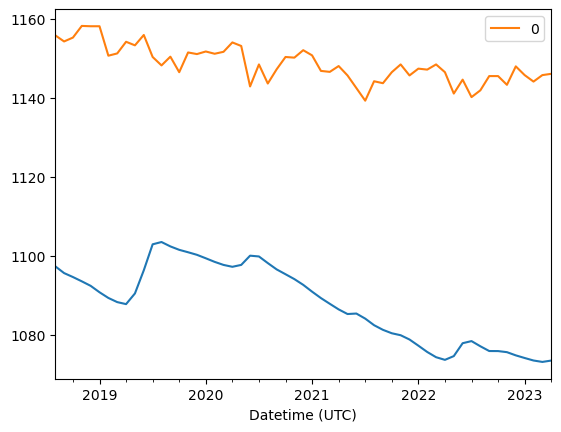

In [18]:
elev_ref_match , elev_pred_match = codebase.time_series_calcs.intersecting_timeframes(elev_ref,elev_pred_df,buffer=0)
ax = elev_ref_match.plot()
elev_pred_match.plot(ax=ax)

In [19]:
print(f'RMSE to USBR: {mean_squared_error(elev_ref_match , elev_pred_match, squared=False)}')

RMSE to USBR: 61.209457471017


## Use model to calculate volume

In [27]:
deltV_ref_m3 = codebase.utils.convert_from_af_to_m3(res_ref['Lake/Reservoir Change In Storage [af]'])

In [21]:
deltV_calc_km2_m = volume_pipeline.calculate_trapezoidal_volume(area=area, elev=elev_pred) # units: km2 * m

In [31]:
deltV_calc_m3 = pd.DataFrame(index=area.index[1:],data=deltV_calc) * (10**6) 

In [38]:
deltV_ref_m3.head()

Datetime (UTC)
2018-01-01   -1.560090e+07
2018-02-01   -1.462380e+07
2018-03-01   -1.543427e+07
2018-04-01   -1.176973e+07
2018-05-01    7.709212e+06
Name: Lake/Reservoir Change In Storage [af], dtype: float64

In [37]:
deltV_calc_m3.head()

,0
2018-09-01,-4.791206e+08
2018-10-01,2.993185e+08
2018-11-01,9.655131e+08
2018-12-01,-2.818817e+07
2019-01-01,0.000000e+00


In [44]:
print(deltV_calc_m3.cumsum().tail())
deltV_ref_m3.cumsum().tail()

                       0
2022-12-01 -2.131823e+09
2023-01-01 -2.601561e+09
2023-02-01 -2.912764e+09
2023-03-01 -2.601561e+09
2023-04-01 -2.535567e+09


Datetime (UTC)
2023-09-01   -2.151791e+08
2023-10-01   -2.178989e+08
2023-11-01   -2.215708e+08
2023-12-01   -2.290496e+08
2024-01-01   -2.396685e+08
Name: Lake/Reservoir Change In Storage [af], dtype: float64